In [8]:
import matplotlib.pyplot as plt
import pandas as p
import torch
import numpy as np
import torch.nn as nn
import os
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import DataLoader, TensorDataset

# Loading the data
Load the datasets 'train images', 'train labels', 'test images', and 'test labels' that have been downloaded and saved in ./datasets. The dataset is a sub-dataset of MNIST including 28*28 greyscale images of handwritten digits

In [2]:
def load_mnist_data(data_dir):
    train_data_path = os.path.join(data_dir, 'train-images.idx3-ubyte')
    train_labels_path = os.path.join(data_dir, 'train-labels.idx1-ubyte')
    test_data_path = os.path.join(data_dir, 't10k-images.idx3-ubyte')
    test_labels_path = os.path.join(data_dir, 't10k-labels.idx1-ubyte')


    # Load training images
    with open(train_data_path, 'rb') as f:
        magic, num_images, rows, cols = np.fromfile(f, dtype=np.dtype('>i4'), count=4)
        train_data = np.fromfile(f, dtype=np.uint8).reshape(num_images, rows, cols)

    # Load training labels
    with open(train_labels_path, 'rb') as f:
        magic, num_labels = np.fromfile(f, dtype=np.dtype('>i4'), count=2)
        train_labels = np.fromfile(f, dtype=np.uint8)

    # Load test images
    with open(test_data_path, 'rb') as f:
        magic, num_images, rows, cols = np.fromfile(f, dtype=np.dtype('>i4'), count=4)
        test_data = np.fromfile(f, dtype=np.uint8).reshape(num_images, rows, cols)

    # Load test labels
    with open(test_labels_path, 'rb') as f:
        magic, num_labels = np.fromfile(f, dtype=np.dtype('>i4'), count=2)
        test_labels = np.fromfile(f, dtype=np.uint8)

    train_mean = np.mean(train_data / 255.)
    print('train mean', train_mean)
    train_std=np.std(train_data / 255.)
    print('train std', train_std)

    # Convert images to torch tensors and apply augmentation transforms
    transform_train = transforms.Compose([
        transforms.ToPILImage(),
        #transforms.RandomCrop(28, padding=4),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    # Normalizing the test images
    transform_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])
   
    train_data = torch.stack([transform_train(img) for img in train_data])
    test_data = torch.stack([transform_test(img) for img in test_data])

    return train_data, train_labels, test_data, test_labels


In [3]:
dataset_path = './dataset'
train_images, train_labels, test_images, test_labels = load_mnist_data(dataset_path)

#print shapes of train_images, train_labels, test_images, test_labels
print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)

# Create DataLoader objects for images and labels
train_images_dataset = TensorDataset(train_images, torch.tensor(train_labels, dtype=torch.long))
test_images_dataset = TensorDataset(test_images, torch.tensor(test_labels, dtype=torch.long))

train_loader = DataLoader(train_images_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_images_dataset, batch_size=32, shuffle=False)


train mean 0.1306604762738429
train std 0.3081078038564622
torch.Size([60000, 1, 28, 28]) (60000,) torch.Size([10000, 1, 28, 28]) (10000,)


In [ ]:
# Any data processing we need to do here?

In [4]:
# tweakable hyperparameters for the model
# loss function and optimizer are placed in the training cell
batch_size = 64
num_of_epochs = 50
learning_rate = 0.00001
neurons_per_layer = 128 # for the hidden layers

numbers_of_layers = 3 # num of hidden layers excl. the input and output layers
activation_function = torch.nn.Sigmoid() # try other activation functions too!

# model
First model to try is a 3 layer neural network model with ReLU activation function. 

In [9]:
# the model
class DigitClassifier(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, num_classes),
            nn.Softmax()
        )
        # input layer
    ##    self.all_layers.add_module('input', torch.nn.Linear(num_features, neurons_per_layer))
      ##  self.all_layers.add_module('input_activation', activation_function)

        # hidden layers
      ##  for i in range(numbers_of_layers):
      ##      self.all_layers.add_module(f'hidden_{i}', torch.nn.Linear(neurons_per_layer, neurons_per_layer))
      ##      self.all_layers.add_module(f'hidden_{i}_activation', activation_function)

        # output layer
     ##   self.all_layers.add_module('output', torch.nn.Linear(neurons_per_layer, num_classes))
    

    def forward(self, x):
        # Flatten the input image
        x = x.view(-1, 28*28)
        x = self.classifier(x)    
        return x
    
# the model
#grey scale, num_channel=1
num_classes = 10
model = DigitClassifier(28*28*1, num_classes)

Second model to try is a mobilenetV2. MobileNetV2 is an improvement over the original MobileNet architecture, introduced in the paper "MobileNetV2: Inverted Residuals and Linear Bottlenecks" by Sandler et al. It introduces inverted residuals with linear bottlenecks and other architectural changes to improve the efficiency and performance of MobileNet.

In [ ]:
######ignore for now ###########
import torchvision.models as models
class ModifiedMobileNetV2(nn.Module):
    def __init__(self, num_classes):
        super(ModifiedMobileNetV2, self).__init__()
        self.mobilenet = mobilenet_v2(pretrained=False)
        self.mobilenet.features[0][0] = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.resize = Resize((224, 224)) 
        # Modify the classifier
        self.mobilenet.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(1280, num_classes),
        )

    def forward(self, x):
        return self.mobilenet(x)
    
model = ModifiedMobileNetV2(num_classes=10) 

In [ ]:
#third model to try
#4 layers cnn with ReLU activation

import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # Flatten the feature maps for the fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN(num_classes=10)

In [10]:
# the training loop

import torch.nn.functional as F
torch.manual_seed(555)

# dimension n of the n*n input MNIST image
n = 28

# number of classes (digits 0-9)
num_classes = 10

# loss and optimizer, try other combos too?
loss_fn = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# also try Adam
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# train!
num_epochs = 100   #increase this to at least 50
epoch_losses = [] # to plot the loss curve later

for epoch in range(num_epochs):

    model = model.train()

    for batch_idx, (images, labels) in enumerate(train_loader):
        #use this version for mobilenet
        images_rgb = torch.cat((images, images, images), dim=1)
        optimizer.zero_grad()
        logits = model(images)
        #print("Shape of target tensor:", labels.shape)
        #print(logits.shape)
        loss = loss_fn(logits, labels) # Loss function
        loss.backward()
        optimizer.step()
    
    # logging + save the loss
    print(f"Epoch: {epoch+1:03d}/{num_epochs:03d}" f" | Batch {batch_idx:03d}/{len(train_loader):03d}" f" | Train Loss: {loss:.2f}")
    epoch_losses.append(loss)


# save model after training
torch.save(model.state_dict(), './model_nn_0430_adam.pth')

/Users/rimokawamoto/Documents/__school/MS_Y2/Spring 24/CSC871/871env/lib/python3.11/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: 001/100 | Batch 1874/1875 | Train Loss: 1.90
Epoch: 002/100 | Batch 1874/1875 | Train Loss: 1.63
Epoch: 003/100 | Batch 1874/1875 | Train Loss: 1.63
Epoch: 004/100 | Batch 1874/1875 | Train Loss: 1.72
Epoch: 005/100 | Batch 1874/1875 | Train Loss: 1.64
Epoch: 006/100 | Batch 1874/1875 | Train Loss: 1.56
Epoch: 007/100 | Batch 1874/1875 | Train Loss: 1.64
Epoch: 008/100 | Batch 1874/1875 | Train Loss: 1.51
Epoch: 009/100 | Batch 1874/1875 | Train Loss: 1.49
Epoch: 010/100 | Batch 1874/1875 | Train Loss: 1.69
Epoch: 011/100 | Batch 1874/1875 | Train Loss: 1.55
Epoch: 012/100 | Batch 1874/1875 | Train Loss: 1.59
Epoch: 013/100 | Batch 1874/1875 | Train Loss: 1.48
Epoch: 014/100 | Batch 1874/1875 | Train Loss: 1.50
Epoch: 015/100 | Batch 1874/1875 | Train Loss: 1.51
Epoch: 016/100 | Batch 1874/1875 | Train Loss: 1.48
Epoch: 017/100 | Batch 1874/1875 | Train Loss: 1.51
Epoch: 018/100 | Batch 1874/1875 | Train Loss: 1.54
Epoch: 019/100 | Batch 1874/1875 | Train Loss: 1.56
Epoch: 020/1

[tensor(1.9044, grad_fn=<NllLossBackward0>), tensor(1.6327, grad_fn=<NllLossBackward0>), tensor(1.6302, grad_fn=<NllLossBackward0>), tensor(1.7184, grad_fn=<NllLossBackward0>), tensor(1.6390, grad_fn=<NllLossBackward0>), tensor(1.5621, grad_fn=<NllLossBackward0>), tensor(1.6367, grad_fn=<NllLossBackward0>), tensor(1.5090, grad_fn=<NllLossBackward0>), tensor(1.4943, grad_fn=<NllLossBackward0>), tensor(1.6947, grad_fn=<NllLossBackward0>), tensor(1.5463, grad_fn=<NllLossBackward0>), tensor(1.5929, grad_fn=<NllLossBackward0>), tensor(1.4770, grad_fn=<NllLossBackward0>), tensor(1.4979, grad_fn=<NllLossBackward0>), tensor(1.5135, grad_fn=<NllLossBackward0>), tensor(1.4847, grad_fn=<NllLossBackward0>), tensor(1.5149, grad_fn=<NllLossBackward0>), tensor(1.5365, grad_fn=<NllLossBackward0>), tensor(1.5598, grad_fn=<NllLossBackward0>), tensor(1.5274, grad_fn=<NllLossBackward0>), tensor(1.5066, grad_fn=<NllLossBackward0>), tensor(1.5371, grad_fn=<NllLossBackward0>), tensor(1.5509, grad_fn=<NllLoss

Text(0, 0.5, 'Training Loss')

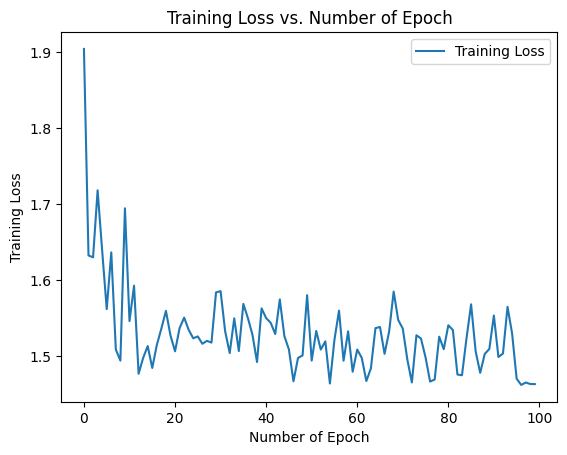

In [11]:
print(epoch_losses)
# training loss plot
plt.plot([loss.detach().numpy() for loss in epoch_losses])
plt.legend(["Training Loss"])
plt.title("Training Loss vs. Number of Epoch")
plt.xlabel("Number of Epoch")
plt.ylabel("Training Loss")

In [ ]:
val_loss = []
total_loss = 0
for epochs in range(num_epochs):
    model.eval()
    for batch_idx, (images, labels) in enumerate(test_loader):
        out = model(images)
        loss = loss_fn(logits, labels)
        total_loss += loss.item()  
        avg_loss = total_loss / len(test_loader)
    # logging + save the loss
    print(f"Epoch: {epoch+1:03d}/{num_epochs:03d}" f" | Batch {batch_idx:03d}/{len(test_loader):03d}" f" | Validation Loss: {loss:.2f}")
    val_loss.append(avg_loss)
    
    
#add some more measurements here: accuracy, confusion matrix, ...